In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plots import *
from kls import *
from utils import *
from objectives import *
from torch.distributions.normal import Normal
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
from torch.distributions.relaxed_categorical import RelaxedOneHotCategorical as rcat
from torch.distributions.gamma import Gamma
import sys
import time
import datetime
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
from probtorch.util import expand_inputs
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [2]:
N = 30
K = 3
D = 2

## Model Parameters
NUM_SAMPLES = 100
STEPS = 10
# NUM_SAMPLES_SNR = 100
NUM_HIDDEN = 16
NUM_STATS = K+D*K+D*K
NUM_LATENTS = D * K
NUM_OBS_GLOBAL = D + K
NUM_OBS_LOCAL = D + K*D + K*D
TEMP = 0.66
## Training Parameters
SAMPLE_DIM = 0
BATCH_DIM = 1
BATCH_SIZE = 50
NUM_EPOCHS = 2000
LEARNING_RATE = 1e-3
CUDA = torch.cuda.is_available()
PATH = 'ag-rws-nonreparam'

In [3]:
Xs = torch.from_numpy(np.load('gmm_dataset/sequences.npy')).float()
Pi = torch.from_numpy(np.load('gmm_dataset/init.npy')).float()
NUM_SEQS = Xs.shape[0]
NUM_BATCHES = int((Xs.shape[0] / BATCH_SIZE))

In [4]:
class Encoder_init(nn.Module):
    def __init__(self, num_obs=D,
                       num_stats=NUM_STATS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_stats = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_stats))

        self.sigmas_log_alpha = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents))
        self.sigmas_log_beta = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents))
        
        self.mus_mean = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents))
        self.mus_log_nu = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents))
        
        self.prior_mean = torch.zeros(K*D)
        self.prior_nu = torch.ones(K*D) * 0.3
        self.prior_alpha = torch.ones(K*D) * 3.0
        self.prior_beta = torch.ones(K*D) * 3.0
        if CUDA:
            self.prior_mean = self.prior_mean.cuda()
            self.prior_nu = self.prior_nu.cuda()
            self.prior_alpha = self.prior_alpha.cuda()
            self.prior_beta = self.prior_beta.cuda()
        
    def forward(self, obs):
        q = probtorch.Trace()
        stats = self.enc_stats(obs).sum(-2) ## B * N * D --> B * STATS_DIM 
        q_alpha = self.sigmas_log_alpha(stats).exp() ## B * K * D
        q_beta = self.sigmas_log_beta(stats).exp() ## B * K * D
        precisions = Gamma(q_alpha, q_beta).sample()
        q.gamma(q_alpha, 
                q_beta, 
                value=precisions,
                name='precisions')
        q_mean = self.mus_mean(stats)
        q_nu = self.mus_log_nu(stats).exp()
        q_sigma = 1. / (q_nu * q['precisions'].value).sqrt() ## S * B * (K*D)
        means = Normal(q_mean, q_sigma).sample()
        q_mu = q.normal(q_mean, 
                        q_sigma, 
                        value=means,
                        name='means')

        p = probtorch.Trace()
        p.gamma(self.prior_alpha, 
                self.prior_beta, 
                value=q['precisions'], 
                name='precisions')
        p.normal(self.prior_mean, 
                 1. / (self.prior_nu * q['precisions'].value).sqrt(), 
                 value=q['means'], 
                 name='means')    
        return q, p

class Encoder_global(nn.Module):
    def __init__(self, num_obs=D+K,
                       num_stats=NUM_STATS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_stats = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_stats))

        self.sigmas_log_alpha = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents))
        self.sigmas_log_beta = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents))
        
        self.mus_mean = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents))
        self.mus_log_nu = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents))
        
        self.prior_mean = torch.zeros(K*D)
        self.prior_nu = torch.ones(K*D) * 0.3
        self.prior_alpha = torch.ones(K*D) * 3.0
        self.prior_beta = torch.ones(K*D) * 3.0
        if CUDA:
            self.prior_mean = self.prior_mean.cuda()
            self.prior_nu = self.prior_nu.cuda()
            self.prior_alpha = self.prior_alpha.cuda()
            self.prior_beta = self.prior_beta.cuda()
        
    def forward(self, q_local, obs):
        q = probtorch.Trace()
        zs = q_local['zs'].value
        data = torch.cat((obs, zs), dim=-1)
        stats = self.enc_stats(data).sum(-2) ## B * N * (D+K) --> B * STATS_DIM 
        q_alpha = self.sigmas_log_alpha(stats).exp() ## B * K * D
        q_beta = self.sigmas_log_beta(stats).exp() ## B * K * D
        precisions = Gamma(q_alpha, q_beta).sample()
        q.gamma(q_alpha, 
                q_beta, 
                value=precisions,
                name='precisions')
        q_mean = self.mus_mean(stats)
        q_nu = self.mus_log_nu(stats).exp()
        q_sigma = 1. / (q_nu * q['precisions'].value).sqrt() ## S * B * (K*D)
        means = Normal(q_mean, q_sigma).sample()
        q_mu = q.normal(q_mean, 
                        q_sigma, 
                        value=means,
                        name='means')

        p = probtorch.Trace()
        p.gamma(self.prior_alpha, 
                self.prior_beta, 
                value=q['precisions'], 
                name='precisions')
        p.normal(self.prior_mean, 
                 1. / (self.prior_nu * q['precisions'].value).sqrt(), 
                 value=q['means'], 
                 name='means')    
        return q, p
    
class Encoder_local(nn.Module):
    def __init__(self, num_obs=NUM_OBS_LOCAL,
                       num_hidden=NUM_HIDDEN,
                       num_latents=K):
        super(self.__class__, self).__init__()
        self.enc_logits = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents))
        
        self.prior_pi = torch.ones(K) * (1./ K)
        if CUDA:
            self.prior_pi = self.prior_pi.cuda()
  
    def forward(self, q_eta, obs):
        q = probtorch.Trace()
        means = q_eta['means'].value.unsqueeze(-2).repeat(1, 1, N, 1)
        precisions = q_eta['precisions'].value.unsqueeze(-2).repeat(1, 1, N, 1)
        data = torch.cat((obs, means, precisions), -1)
        q_logit = self.enc_logits(data)## S * B * N * (D+2*K*D) --> S * B * N * K
        zs = rcat(temperature=torch.Tensor([TEMP]).cuda(), logits=q_logit).sample()
        q.concrete(temperature=torch.Tensor([TEMP]).cuda(), 
                                      logits=q_logit,
                                      value=zs,
                                      name='zs')

        p = probtorch.Trace()
        p.concrete(temperature=torch.Tensor([TEMP]).cuda(), 
                                      logits=torch.log(self.prior_pi),
                                      value=q['zs'], 
                                      name='zs')  
        return q, p
    
def initialize():
    enc_init = Encoder_init()
    enc_global = Encoder_global()
    enc_local = Encoder_local()
    if CUDA:
        enc_init.cuda()
        enc_local.cuda()
        enc_global.cuda()
    optimizer =  torch.optim.Adam(list(enc_init.parameters()) + list(enc_global.parameters()) + list(enc_local.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))    
    return enc_init, enc_global, enc_local, optimizer

In [5]:
enc_init, enc_global, enc_local, optimizer = initialize()

In [6]:
EUBOs = []
ELBOs = []
ESSs = []
KLs_eta_ex = []
KLs_eta_in = []
KLs_z_ex = []
KLs_z_in = []

flog = open('results/log-' + PATH + '.txt', 'w+')
flog.write('EUBO, ELBO, ESS, KLs_eta_ex_os, KLs_eta_in_os, KL_z_ex_os, KL_z_in_os\n')
flog.close()

for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    indices = torch.randperm(NUM_SEQS)
    EUBO = 0.0
    ELBO = 0.0
    ESS = 0.0
    KL_eta_ex_os = 0.0
    KL_eta_in_os = 0.0
    KL_z_ex_os = 0.0
    KL_z_in_os = 0.0
    for step in range(NUM_BATCHES):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        data = Xs[batch_indices]
        data = shuffler(data, N, K, D, BATCH_SIZE)
        if CUDA:
            data =data.repeat(NUM_SAMPLES, 1, 1, 1).cuda()
        
        eubo, elbo, ess, KL_eta_ex, KL_eta_in, KL_z_ex, KL_z_in = ag_rws_overall(enc_init, enc_global, enc_local, data, N, K, D, SAMPLE_DIM, BATCH_DIM, STEPS, NUM_SAMPLES, BATCH_SIZE)
        eubo.backward()
        optimizer.step()
        EUBO += eubo.item()
        ELBO += elbo.item()
        ESS += ess.item()
        KL_eta_ex_os += KL_eta_ex.item()
        KL_eta_in_os += KL_eta_in.item()
        KL_z_ex_os += KL_z_ex.item()
        KL_z_in_os += KL_z_in.item()       
        flog = open('results/log-' + PATH + '.txt', 'a+')
        flog.write(str(eubo.item()) + ', ' + str(elbo.item()) + ', ' + str(ess.item()) + ', ' + 
               str(KL_eta_ex.item()) + ', ' + str(KL_eta_in.item()) + ', ' + str(KL_z_ex.item()) + ', ' + str(KL_z_in.item()) + '\n')
             
    EUBO /= NUM_BATCHES
    ELBO /= NUM_BATCHES
    ESS /= NUM_BATCHES
    KL_eta_ex_os /= NUM_BATCHES
    KL_eta_in_os /= NUM_BATCHES
    KL_z_ex_os /= NUM_BATCHES
    KL_z_in_os /= NUM_BATCHES 
    
    EUBOs.append(EUBO)
    ELBOs.append(ELBO)
    ESSs.append(ESS) 
    KLs_eta_ex.append(KL_eta_ex_os)
    KLs_eta_in.append(KL_eta_in_os)
    KLs_z_ex.append(KL_z_ex_os)
    KLs_z_in.append(KL_z_in_os)
    time_end = time.time()
    print('epoch=%d, EUBO=%.3f, ELBO=%.3f, ESS=%.3f, EX_eta=%.3f, IN_eta=%.3f, EX_z=%.3f, IN_z=%.3f (%ds)'
            % (epoch, EUBO, ELBO, ESS,  KL_eta_ex_os, KL_eta_in_os, KL_z_ex_os, KL_z_in_os, time_end - time_start))


epoch=0, EUBO=-334.646, ELBO=-533.777, ESS=1.015, EX_eta=119771.564, IN_eta=27141.593, EX_z=145.759, IN_z=19.699 (5s)
epoch=1, EUBO=-230.524, ELBO=-307.957, ESS=1.032, EX_eta=109559.010, IN_eta=814.471, EX_z=49.701, IN_z=14.040 (5s)
epoch=2, EUBO=-209.998, ELBO=-258.092, ESS=1.050, EX_eta=400236.521, IN_eta=258.062, EX_z=29.059, IN_z=11.014 (5s)
epoch=3, EUBO=-200.150, ELBO=-235.600, ESS=1.078, EX_eta=282.304, IN_eta=53.724, EX_z=22.267, IN_z=9.456 (5s)
epoch=4, EUBO=-193.509, ELBO=-221.517, ESS=1.092, EX_eta=86.834, IN_eta=40.191, EX_z=17.000, IN_z=8.097 (5s)
epoch=5, EUBO=-189.222, ELBO=-212.814, ESS=1.099, EX_eta=48.827, IN_eta=48.158, EX_z=13.462, IN_z=7.283 (5s)
epoch=6, EUBO=-186.384, ELBO=-206.975, ESS=1.134, EX_eta=38.506, IN_eta=26.626, EX_z=11.368, IN_z=6.838 (5s)
epoch=7, EUBO=-183.882, ELBO=-203.337, ESS=1.121, EX_eta=37.027, IN_eta=50.310, EX_z=10.161, IN_z=6.507 (5s)
epoch=8, EUBO=-182.079, ELBO=-200.631, ESS=1.143, EX_eta=84.914, IN_eta=30.183, EX_z=9.051, IN_z=6.496 (5s

KeyboardInterrupt: 

In [11]:
def plot_results(EUBOs, ELBOs, ESSs, KLs_eta_ex, KLs_eta_in, KLs_z_ex, KLs_z_in, num_samples, num_epochs, lr):
    fig = plt.figure(figsize=(15, 15))
    fig.tight_layout()
    ax1 = fig.add_subplot(3, 1, 1)
    ax2 = fig.add_subplot(3, 1, 2)
    ax3 = fig.add_subplot(3, 1, 3)
    ax1.plot(EUBOs, 'r', label='EUBOs')
    ax1.plot(ELBOs, 'b', label='ELBOs')

    ax2.plot(KLs_eta_ex, '#66b3ff', label='exclusive KL -- eta')
    ax2.plot(KLs_eta_in, '#ff9999', label='inclusive KL -- eta')
    ax2.plot(KLs_z_ex, '#99ff99', label='exclusive KL -- z')
    ax2.plot(KLs_z_in, 'gold', label='inclusive KL -- z')
    ax1.tick_params(labelsize=18)
    
    ax3.plot(np.array(ESSs) / num_samples, 'm', label='ESS')
    ax1.set_title('epoch=%d, batch_size=%d, lr=%.1E, samples=%d' % (num_epochs, BATCH_SIZE, lr, num_samples), fontsize=18)
    ax1.set_ylim([-200, -120])
    ax1.legend()
    ax2.set_ylim([0.0, 20])
    ax2.legend()
    ax3.legend()
    ax2.tick_params(labelsize=18)
    ax3.tick_params(labelsize=18)
    plt.savefig('train_' + PATH + '.svg')

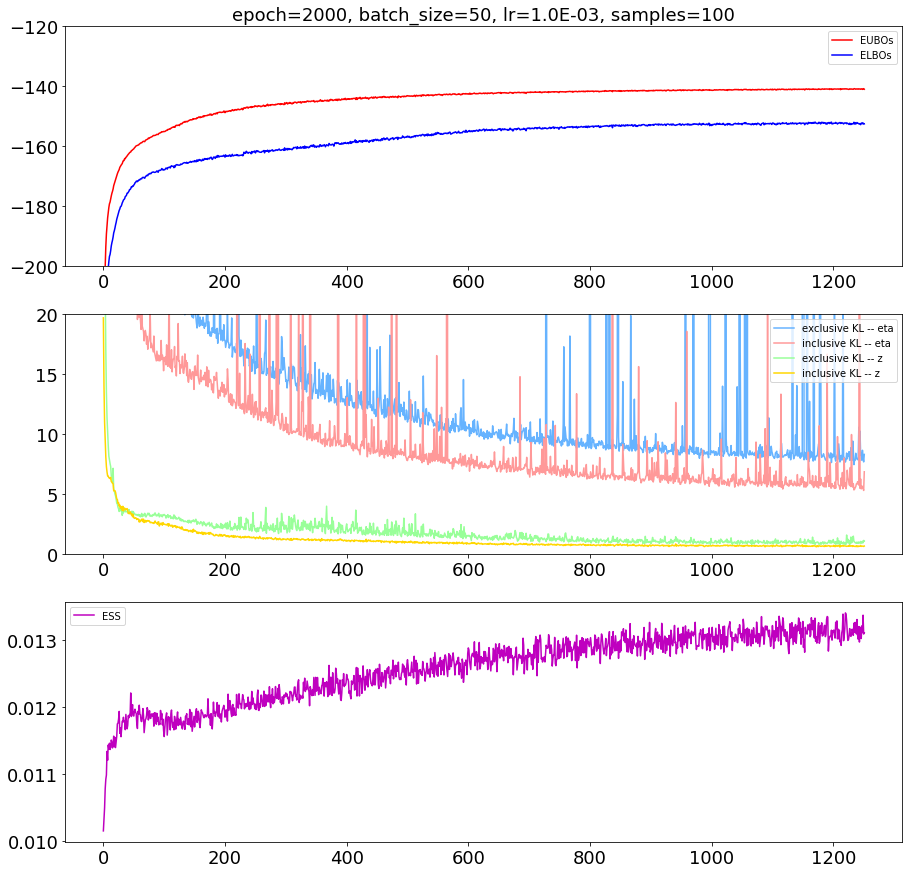

In [12]:
plot_results(EUBOs, ELBOs, ESSs, KLs_eta_ex, KLs_eta_in, KLs_z_ex, KLs_z_in, NUM_SAMPLES, NUM_EPOCHS, LEARNING_RATE)

In [13]:
def sample_single_batch(num_seqs, N, K, D, batch_size):
    indices = torch.randperm(num_seqs)
    batch_indices = indices[0*batch_size : (0+1)*batch_size]
    batch_Xs = Xs[batch_indices]
    batch_Xs = shuffler(batch_Xs, N, K, D, batch_size).repeat(1, 1, 1, 1)
    if CUDA:
        batch_Xs = batch_Xs.repeat(1, 1, 1, 1).cuda()
    return batch_Xs

data = sample_single_batch(NUM_SEQS, N, K, D, batch_size=25)

for m in range(STEPS):
    if m == 0:
        q_eta, p_eta = enc_init(data)
        q_z, p_z = enc_local(q_eta, data)
    else:
        q_eta, p_eta = enc_global(q_z, data)
        q_z, p_z = enc_local(q_eta, data)

In [16]:
def plot_samples(data, q_eta, q_z, batch_size):
    colors = ['r', 'b', 'gold']
    fig = plt.figure(figsize=(25,25))
    covs = q_eta['precisions']
    Xs = data[0].cpu()
    Zs = q_z['zs'].dist.probs[0].cpu()
    alphas = q_eta['precisions'].dist.concentration[0].cpu().data.numpy()
    betas = q_eta['precisions'].dist.rate[0].cpu().data.numpy()
    precisions_mean = alphas / betas
    covs_mean = (1. / precisions_mean)
    means_mean = q_eta['means'].dist.loc[0].cpu().data.numpy()

    for b in range(batch_size):
        ax = fig.add_subplot(int(batch_size / 5), 5, b+1)
        x = Xs[b].data.numpy()
        z = Zs[b].data.numpy()
#         covs = np.zeros((K, D, D))
        mu = means_mean[b].reshape(K, D)
        cov = covs_mean[b].reshape(K, D)
        assignments = z.argmax(-1)
        for k in range(K):
            cov_k = np.diag(cov[k])
            xk = x[np.where(assignments == k)]
            ax.scatter(xk[:, 0], xk[:, 1], c=colors[k])
#             ax.scatter(x[:, 0], x[:, 1])
            plot_cov_ellipse(cov=cov_k, pos=mu[k], nstd=2, ax=ax, alpha=0.2, color=colors[k])
        ax.set_ylim([-10, 10])
        ax.set_xlim([-10, 10])
    plt.savefig('results/modes' + PATH + '.svg')

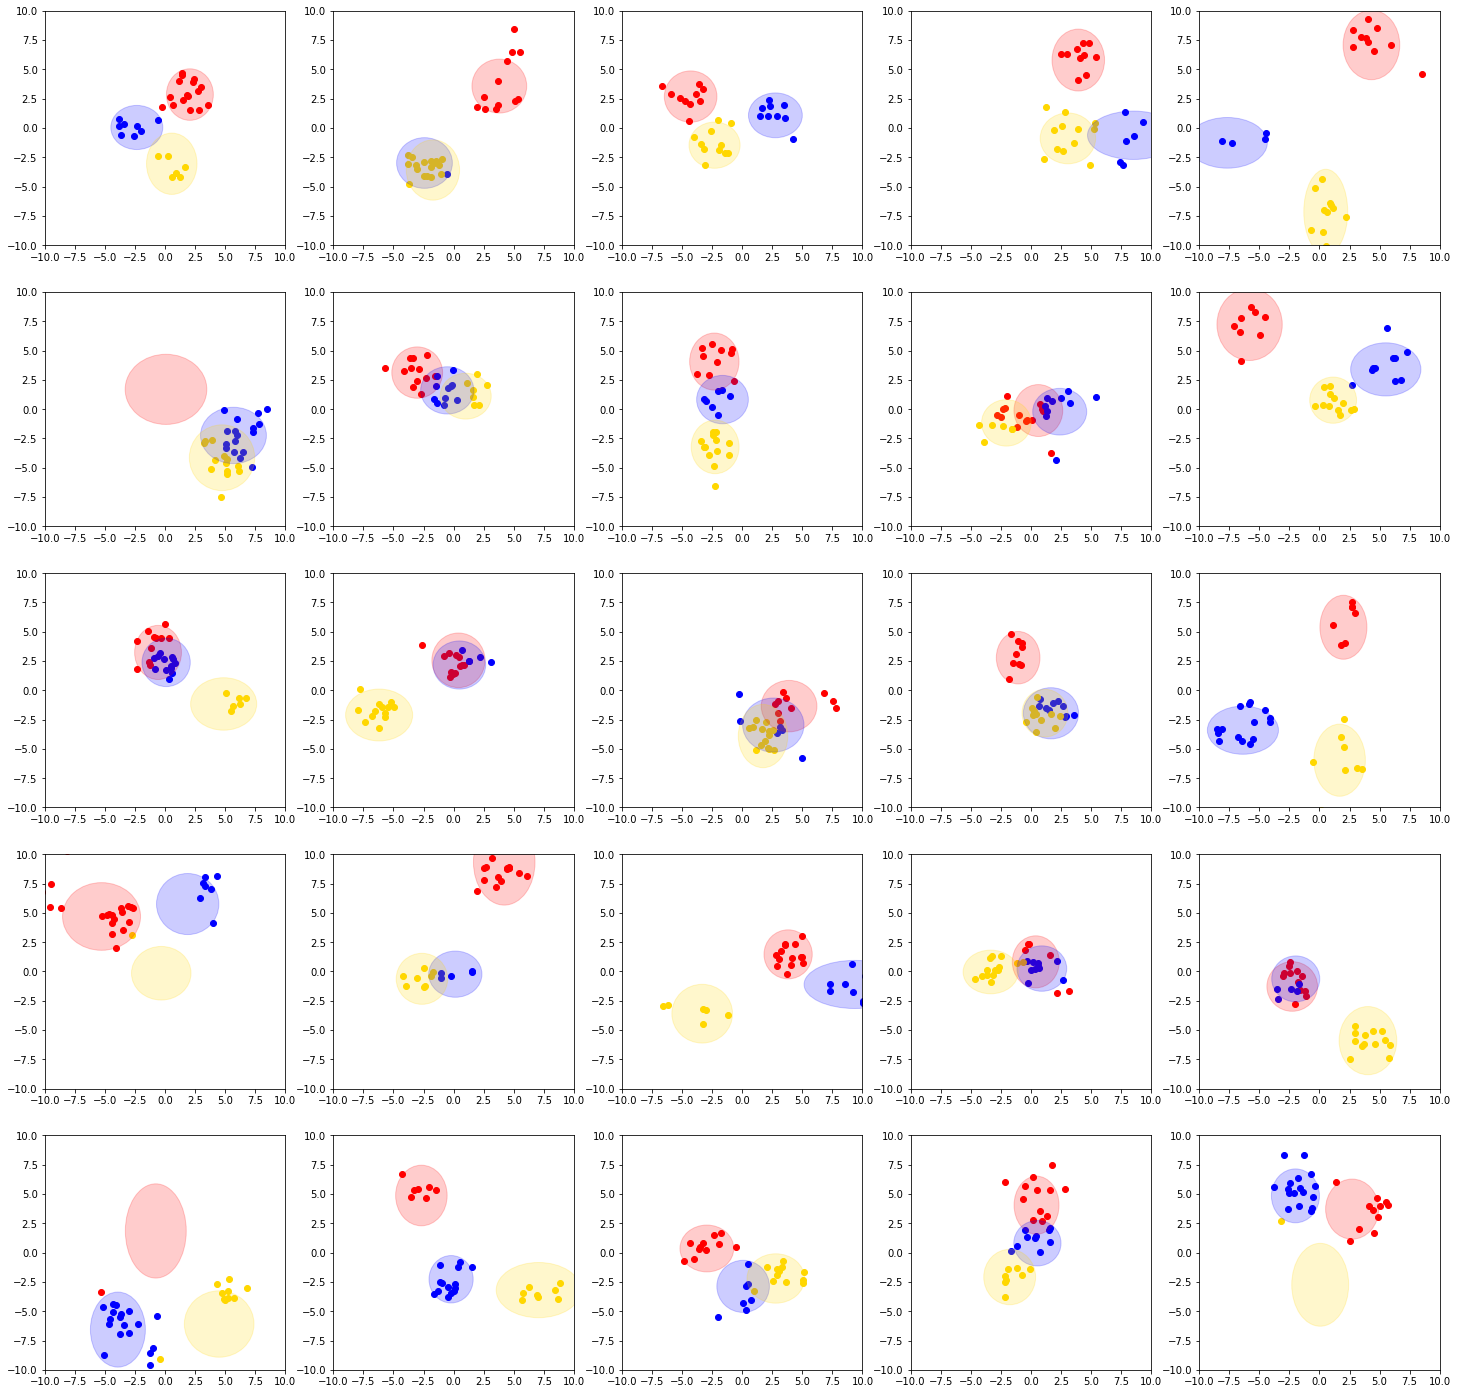

In [17]:
plot_samples(data, q_eta, q_z, batch_size=25)